In [1]:
#dependencies
import requests
import os
import pandas as pd
import statistics
from pandas import Series
from matplotlib import pyplot as plt
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
import numpy
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.ar_model import ARResults

In [2]:
state =  "WV"
choice = "../Data/cancer.csv"
race = "White"
sex = 'Male'

In [3]:
choice_df = pd.read_csv(choice)

In [4]:
choice_df = choice_df.fillna(0)
choice_df = choice_df.replace("Not Applicable", 0)
choice_df["Crude Rate"] = choice_df["Crude Rate"].astype(float)

In [5]:
index = choice_df.Year.unique()
larynx = choice_df[(choice_df["Race"] == race ) & (choice_df["State"] == state) & (choice_df["Cancer Sites"]=="Larynx") & (choice_df["Sex"]==sex)]["Crude Rate"].values
lung = choice_df[(choice_df["Race"] == race )&(choice_df["State"] == state) & (choice_df["Cancer Sites"]=="Lung and Bronchus")& (choice_df["Sex"]==sex)]["Crude Rate"].values
nasal = choice_df[(choice_df["Race"] == race )&(choice_df["State"] == state) & (choice_df["Cancer Sites"]=="Nose, Nasal Cavity and Middle Ear")& (choice_df["Sex"]==sex)]["Crude Rate"].values
trachea = choice_df[(choice_df["Race"] == race )&(choice_df["State"] == state) & (choice_df["Cancer Sites"]=="Trachea, Mediastinum and Other Respiratory Organs")& (choice_df["Sex"]==sex)]["Crude Rate"].values



In [6]:
cancers = [larynx, lung, nasal, trachea]
prediction_X = [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]

In [7]:
for cancer in cancers:
    if len(cancer) > 0:
        index = range(len(cancer))
        series = pd.Series(cancer, index = index)  
        print(cancer)


[11.8 10.8 11.6 11.2  9.5  9.3 11.5 10.1 11.  11.3 11.6 11.2 10.7 11.5
 11.1 11.7 11.1]
[137.7 133.  133.6 131.4 125.  133.4 134.9 135.1 126.4 129.4 132.1 123.2
 132.5 124.8 128.5 126.1 128.7]
[2.2]


In [8]:
def model_plots(series):
    
    # create a difference transform of the dataset
    def difference(dataset):
        diff = list()
        for i in range(1, len(dataset)):
            value = dataset[i] - dataset[i - 1]
            diff.append(value)
        return numpy.array(diff)

    # Make a prediction give regression coefficients and lag obs
    def predict(coef, history):
        yhat = coef[0]
        for i in range(1, len(coef)):
            yhat += coef[i] * history[-i]
        return yhat


    # split dataset
    X = difference(series.values)
    size = int(len(X) * 0.80)
    train, test = X[0:size], X[size:]
    # train autoregression
    model = AR(train)
    model_fit = model.fit(maxlag=3, disp=True)
    window = model_fit.k_ar
    coef = model_fit.params
    # walk forward over time steps in test
    history = [train[i] for i in range(len(train))]
    predictions = list()
    for t in range(len(test)):
        yhat = predict(coef, history)
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
    error = mean_squared_error(test, predictions)
    print('Test MSE: %.3f' % error)
    # plot
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.show()

Test MSE: 0.257


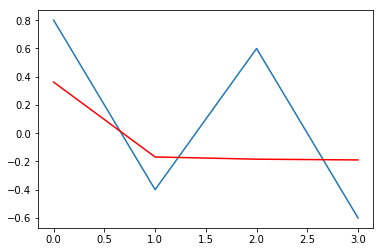

Test MSE: 11.343


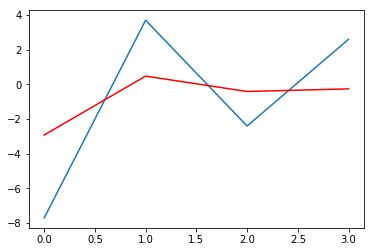

In [9]:
for cancer in cancers:
    if len(cancer) > 0:
        index = range(len(cancer))
        series = pd.Series(cancer, index = index)  
        if len(cancer) > 1:
            model_plots(series)

In [10]:
def ar_data(series):

    def difference(dataset):
        diff = list()
        for i in range(1, len(dataset)):
            value = dataset[i] - dataset[i - 1]
            diff.append(value)
        return numpy.array(diff)

    # load dataset
    X = difference(series.values)
    # fit model
    model = AR(X)
    model_fit = model.fit(maxlag=3, disp=False)
    # save model to file
    model_fit.save('../Model_Info/ar_model.pkl')
    # save the differenced dataset
    numpy.save('../Model_Info/ar_data.npy', X)
    # save the last ob
    numpy.save('../Model_Info/ar_obs.npy', [series.values[-1]])# load the AR model from file
    loaded = ARResults.load('../Model_Info/ar_model.pkl')
    print(loaded.params)
    data = numpy.load('../Model_Info/ar_data.npy')
    print(data)
    last_ob = numpy.load('../Model_Info/ar_obs.npy')
    print(last_ob)

In [11]:
for cancer in cancers:
    if len(cancer) > 0:
        index = range(len(cancer))
        series = pd.Series(cancer, index = index)  
        if len(cancer) > 1:
            ar_data(series)

[ 0.00448037 -0.55921695 -0.44832038 -0.10724348]
[-1.   0.8 -0.4 -1.7 -0.2  2.2 -1.4  0.9  0.3  0.3 -0.4 -0.5  0.8 -0.4
  0.6 -0.6]
[11.1]
[-1.19752263 -0.89277828 -0.557354   -0.28402047]
[-4.7  0.6 -2.2 -6.4  8.4  1.5  0.2 -8.7  3.   2.7 -8.9  9.3 -7.7  3.7
 -2.4  2.6]
[128.7]


In [12]:
def predict(series):
# load dataset
    def difference(dataset):
        diff = list()
        for i in range(1, len(dataset)):
            value = dataset[i] - dataset[i - 1]
            diff.append(value)
        return numpy.array(diff)

    import numpy
    X = difference(series.values)
    # fit model
    window_size = 3
    model = AR(X)
    model_fit = model.fit(maxlag=window_size, disp=False)
    # save coefficients
    coef = model_fit.params
    numpy.save('../Model_Info/man_model.npy', coef)
    # save lag
    lag = X[-window_size:]
    numpy.save('../Model_Info/man_data.npy', lag)
    # save the last ob
    numpy.save('../Model_Info/man_obs.npy', [series.values[-1]])
    coef = numpy.load('../Model_Info/man_model.npy')
    lag = numpy.load('../Model_Info/man_data.npy')
    last_ob = numpy.load('../Model_Info/man_obs.npy')

    
    yhat = []
    for prediction in prediction_X:
        import numpy
        def predict(coef, history):
            yhat = coef[0]
            for i in range(1, len(coef)):
                yhat += coef[i] * history[-i]
            return yhat

        # load model
        coef = numpy.load('../Model_Info/man_model.npy')
        lag = numpy.load('../Model_Info/man_data.npy')
        last_ob = numpy.load('../Model_Info/man_obs.npy')
        # make prediction
        prediction = predict(coef, lag)
        # transform prediction
        y_predict = prediction + last_ob[0]
        yhat.append(y_predict)
        # get real observation
        observation = prediction
        # update and save differenced observation
        lag = numpy.load('../Model_Info/man_data.npy')
        last_ob = numpy.load('../Model_Info/man_obs.npy')
        diffed = observation - last_ob[0]
        lag = numpy.append(lag[1:], [diffed], axis=0)
        numpy.save('../Model_Info/man_data.npy', lag)
        # update and save real observation
        last_ob[0] = observation
        numpy.save('../Model_Info/man_obs.npy', last_ob)

    print(yhat)
    yhat_list.append(yhat)

In [13]:
yhat_list = []
for cancer in cancers:
    if len(cancer) > 0:
        index = range(len(cancer))
        series = pd.Series(cancer, index = index)  
        if len(cancer) > 1:
            predict(series)   

[11.213915700928542, 6.4666467549071145, 7.857991722641186, 2.6017265127105014, 2.833698683526639, 2.086516104958708, 0.8865002362572882, 0.9901296212340792, 0.5691314590493295, 0.3266247579910268]
[125.46802771013228, 112.5890331263557, 81.12992968055435, 69.60204572830312, 29.08855446272537, 49.13466140130768, 5.562737390776903, 36.83890501479327, -11.726246870791329, 35.90628864446734]


In [14]:
for i in range (0, len(yhat_list)):
    cancers[i]= pd.Series(cancers[i])
    yhat_list[i]= pd.Series(yhat_list[i])
    cancers[i]= cancers[i].append(yhat_list[i])
    cancers[i].reset_index()
    
        

In [15]:
cancers

[0     11.800000
 1     10.800000
 2     11.600000
 3     11.200000
 4      9.500000
 5      9.300000
 6     11.500000
 7     10.100000
 8     11.000000
 9     11.300000
 10    11.600000
 11    11.200000
 12    10.700000
 13    11.500000
 14    11.100000
 15    11.700000
 16    11.100000
 0     11.213916
 1      6.466647
 2      7.857992
 3      2.601727
 4      2.833699
 5      2.086516
 6      0.886500
 7      0.990130
 8      0.569131
 9      0.326625
 dtype: float64, 0     137.700000
 1     133.000000
 2     133.600000
 3     131.400000
 4     125.000000
 5     133.400000
 6     134.900000
 7     135.100000
 8     126.400000
 9     129.400000
 10    132.100000
 11    123.200000
 12    132.500000
 13    124.800000
 14    128.500000
 15    126.100000
 16    128.700000
 0     125.468028
 1     112.589033
 2      81.129930
 3      69.602046
 4      29.088554
 5      49.134661
 6       5.562737
 7      36.838905
 8     -11.726247
 9      35.906289
 dtype: float64, array([2.2]), array([]

In [16]:
index = pd.Series(choice_df.Year.unique())
prediction_X = pd.Series(prediction_X)
index = index.append(prediction_X)
index=index.values

In [33]:
len(yhat_list)

2

In [38]:
if len(yhat_list) == 2:
    data_with_predict = pd.DataFrame({"Year": index, "Lung" :cancers[0], "Larynx": cancers[1]})
elif len(yhat_list) == 1:    
    data_with_predict = pd.DataFrame({"Year": index, "Lung" :cancers[0]})
elif len(yhat_list) == 3:   
    data_with_predict = pd.DataFrame({"Year": index, "Lung" :cancers[0], "Larynx": cancers[1], "Nasal":cancers[2]})
elif len(yhat_list) == 4:   
    data_with_predict = pd.DataFrame({"Year": index, "Lung" :cancers[0], "Larynx": cancers[1], "Nasal":cancers[2], "Trachea": cancers[3]})    
    

In [39]:
data_with_predict

,Year,Lung,Larynx
0,1999,11.800000,137.700000
1,2000,10.800000,133.000000
2,2001,11.600000,133.600000
3,2002,11.200000,131.400000
4,2003,9.500000,125.000000
5,2004,9.300000,133.400000
6,2005,11.500000,134.900000
7,2006,10.100000,135.100000
8,2007,11.000000,126.400000
9,2008,11.300000,129.400000


In [ ]:
data_with_predict